In [1]:
# uni_D83AE5_uni (Baseline)
import pandas as pd
# Importing necessary libraries for logistic regression and scaling
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import log_loss
# Load the data
training_data = pd.read_csv('training_data.csv')

# Drop rows where BORROWER_ID is 'xNullx'
training_data = training_data[training_data['BORROWER_ID'] != 'xNullx']

# Shuffle the DataFrame
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)

data_submission_example = pd.read_csv('data_submission_example.csv')


In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming training_data =  training_data.sample(n=10000, random_state=1)

# Filling NaN values with 0
training_data.fillna(0, inplace=True)

# Converting columns to numeric where possible
for col in training_data.columns:
    try:
        training_data[col] = pd.to_numeric(training_data[col], errors='ignore')
    except:
        continue

# Creating a sample target variable
training_data['TARGET_EVENT_BINARY'] = np.where(training_data['TARGET_EVENT'] == 'K', 1, 0)

In [3]:
lognormal_variables = [
    'CONTRACT_CREDIT_LOSS', 'CONTRACT_DEPT_SERVICE_TO_INCOME',
    'CONTRACT_INCOME', 'CONTRACT_INSTALMENT_AMOUNT', 'CONTRACT_INSTALMENT_AMOUNT_2',
    'CONTRACT_LOAN_AMOUNT', 'CONTRACT_MARKET_VALUE', 'CONTRACT_MORTGAGE_LENDING_VALUE', 
    'CONTRACT_LGD', 'CONTRACT_INCOME'
]
date_variables = ['CONTRACT_DATE_OF_LOAN_AGREEMENT', 'CONTRACT_MATURITY_DATE']

In [4]:
training_data['TARGET_EVENT_DAY'].replace(0.0, np.nan, inplace=True)
training_data['TARGET_EVENT_DAY_JULIAN'] = pd.to_datetime(training_data['TARGET_EVENT_DAY'], origin='julian', unit='D', errors='coerce')
training_data['TARGET_EVENT_DAY_DATETIME'] = pd.to_datetime(training_data['TARGET_EVENT_DAY_JULIAN'],  errors='coerce')

training_data[ 'CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'], origin='julian', unit='D')
training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'],)

training_data['CONTRACT_MATURITY_DATE_JULIAN'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE'], origin='julian', unit='D')
training_data['CONTRACT_MATURITY_DATE_DATETIME'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE_JULIAN'])

In [5]:
training_data['DAY_DIFF_TARGET'] = (training_data['TARGET_EVENT_DAY_DATETIME'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days

In [6]:
training_data['DAY_DIFF_TARGET'].value_counts(dropna=False)

DAY_DIFF_TARGET
NaN       1547322
1.0           356
28.0          207
7.0           206
29.0          178
           ...   
1050.0          1
975.0           1
1058.0          1
1000.0          1
1047.0          1
Name: count, Length: 1105, dtype: int64

In [7]:

# Calculate the day difference
training_data['DAY_DIFF'] = (training_data['TARGET_EVENT_DAY_DATETIME'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days

# Create TARGET_EVENT_BINARY_2Y based on conditions
training_data['TARGET_EVENT_BINARY_2Y'] = np.where(
    (training_data['TARGET_EVENT'] == 'K') & 
    (training_data['DAY_DIFF'] <= 730) & 
    (training_data['DAY_DIFF'] >= 0), 
    1, 
    0
)
training_data['TARGET_EVENT_BINARY_1Y'] = np.where(
        (training_data['TARGET_EVENT'] == 'K') & 
        (training_data['DAY_DIFF'] <= 365) & 
        (training_data['DAY_DIFF'] >= 0), 
        1, 
        0
    )
# Drop the temporary 'DAY_DIFF' column if needed
training_data.drop('DAY_DIFF', axis=1, inplace=True)

In [8]:
# Identify numeric columns
numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()

# Identify target columns that shouldn't be in the X variables
excluded_keywords = ['TARGET', 'event', 'binary', 'DATE']

# Create lists for X variable columns and target column
X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
y_column = 'TARGET_EVENT_BINARY_2Y' 
X_columns

['CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_CREDIT_LOSS',
 'CONTRACT_CURRENCY',
 'CONTRACT_DEPT_SERVICE_TO_INCOME',
 'CONTRACT_INCOME',
 'CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_INSTALMENT_AMOUNT_2',
 'CONTRACT_INTEREST_PERIOD',
 'CONTRACT_INTEREST_RATE',
 'CONTRACT_LGD',
 'CONTRACT_LOAN_AMOUNT',
 'CONTRACT_LOAN_CONTRACT_TYPE',
 'CONTRACT_LOAN_TO_VALUE_RATIO',
 'CONTRACT_MARKET_VALUE',
 'CONTRACT_MORTGAGE_LENDING_VALUE',
 'CONTRACT_MORTGAGE_TYPE',
 'CONTRACT_REFINANCED',
 'CONTRACT_RISK_WEIGHTED_ASSETS',
 'CONTRACT_TYPE_OF_INTEREST_REPAYMENT',
 'BORROWER_BIRTH_YEAR',
 'BORROWER_CITIZENSHIP',
 'BORROWER_COUNTRY',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT']

In [9]:
# One-hot encode the 'CONTRACT_LOAN_TYPE' and 'CONTRACT_FREQUENCY_TYPE' columns
loan_type_dummies = pd.get_dummies(training_data['CONTRACT_LOAN_TYPE'], prefix='LOAN_TYPE', drop_first=True)
frequency_type_dummies = pd.get_dummies(training_data['CONTRACT_FREQUENCY_TYPE'], prefix='FREQ_TYPE', drop_first=True)

# Concatenate the original DataFrame with the one-hot encoded columns
training_data = pd.concat([training_data, loan_type_dummies, frequency_type_dummies], axis=1)

# Add the names of the one-hot encoded columns to X_columns
X_columns.extend(loan_type_dummies.columns)
X_columns.extend(frequency_type_dummies.columns)



In [10]:
training_data['BORROWER_LOAN_COUNT'] = training_data.groupby('BORROWER_ID')['BORROWER_ID'].transform('count')
training_data['TOTAL_LOAN_AMOUNT'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_1'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_2'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT_2'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT'] = training_data['TOTAL_INSTALLMENT_AMOUNT_1'] + training_data['TOTAL_INSTALLMENT_AMOUNT_2']
# training_data['AVERAGE_LOAN_AMOUNT'] = training_data['TOTAL_LOAN_AMOUNT'] / training_data['BORROWER_LOAN_COUNT']
# training_data['AVERAGE_LOAN_TERM'] = training_data.groupby('BORROWER_ID')['CONTRACT_MATURITY_DATE'].transform('mean')
# training_data['AVERAGE_INTEREST_RATE'] = training_data.groupby('BORROWER_ID')['CONTRACT_INTEREST_RATE'].transform('mean')
# training_data['MAX_DEBT_TO_INCOME'] = training_data.groupby('BORROWER_ID')['CONTRACT_DEPT_SERVICE_TO_INCOME'].transform('max')
# training_data['HAS_MULTIPLE_LOAN_TYPES'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_TYPE'].transform('nunique').apply(lambda x: 1 if x > 1 else 0)
# training_data['HAS_REFINANCED'] = training_data.groupby('BORROWER_ID')['CONTRACT_REFINANCED'].transform('max')

# # # training_data['RELATIVE_LOAN_AMOUNT'] = training_data['CONTRACT_LOAN_AMOUNT'] / training_data['TOTAL_LOAN_AMOUNT']
# training_data['IS_FIXED_RATE'] = training_data['CONTRACT_LOAN_CONTRACT_TYPE'].apply(lambda x: 1 if x == 'fixed' else 0)
# # Ez még nem tudom hogyan de hasznos lehet 
# # Assuming CONTRACT_MATURITY_DATE is a datetime object and 'current_date' is today's date
# # training_data['DAYS_TO_MATURITY'] = (training_data['CONTRACT_MATURITY_DATE'] - current_date).dt.days
X_columns.extend(['BORROWER_LOAN_COUNT', 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT'])
lognormal_variables.extend([ 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT'])

In [11]:
threshold = 0.85  # Set your own threshold
correlation_matrix = training_data[X_columns].corr()
# Get pairs of highly correlated features
highly_correlated_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_set.add(colname)

# Remove highly correlated features from X_columns
X_columns = [col for col in X_columns if col not in highly_correlated_set]
print('Variables removed:', highly_correlated_set)

Variables removed: {'CONTRACT_REFINANCED', 'BORROWER_COUNTRY', 'FREQ_TYPE_2f88e16c'}


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering

import numpy as np

def filter_2016(df1, df2, variables):
    # Create deep copies to avoid modifying original data
    df1_copy = df1.copy()
    df2_copy = df2.copy()

    # Convert to datetime format if not already
    df1_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'] = pd.to_datetime(df1_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'])
    df2_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'] = pd.to_datetime(df2_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'])
    
    # Filter data where CONTRACT_DATE_OF_LOAN_AGREEMENT is before 2016
    df1_filtered = df1_copy[df1_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'].dt.year < 2016]
    df2_filtered = df2_copy[df2_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT'].dt.year < 2016]
    
    df1_filtered['CONTRACT_DATE_OF_LOAN_AGREEMENT'] = df1_filtered['CONTRACT_DATE_OF_LOAN_AGREEMENT'].apply(lambda x: x.toordinal())
    df2_filtered['CONTRACT_DATE_OF_LOAN_AGREEMENT'] = df2_filtered['CONTRACT_DATE_OF_LOAN_AGREEMENT'].apply(lambda x: x.toordinal())

    return df1_filtered, df2_filtered

def train_and_predict(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    # Split the dataframe into two halves
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    half = len(df) // 2
    df1, df2 = df.iloc[:half], df.iloc[half:]
    X_scaled = scaler.fit_transform(df[variables])
    y = df[target]
    model1.fit(X_scaled, y)

        
    print("CLUSTERING:")
    
    # Create a DataFrame to store all clustering labels
    df_clusters = pd.DataFrame()
    df_clusters['original_index'] = df.index
    
    # KMeans Clustering
      # KMeans Clustering
    for CLUSTER_COUNT in range(6, 12, 2):  # starting from 2, going up by 2, until 10
        kmeans = KMeans(n_clusters=CLUSTER_COUNT, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        col_name = f'KMeans_{CLUSTER_COUNT}'
        df_clusters[col_name] = kmeans.labels_
        
        # Evaluation Metrics for KMeans
        inertia = kmeans.inertia_
        silhouette = silhouette_score(X_scaled, kmeans.labels_)
        db_score = davies_bouldin_score(X_scaled, kmeans.labels_)
        
        print(f"For KMeans with {CLUSTER_COUNT} clusters: Inertia = {inertia}, Silhouette Score = {silhouette}, Davies-Bouldin Index = {db_score}")
    
    # Hierarchical Clustering
    agglomerative = AgglomerativeClustering(n_clusters=10)
    agglomerative.fit(X_scaled)
    df_clusters['Agglomerative'] = agglomerative.labels_
    
    # Evaluation Metrics for Agglomerative Clustering
    silhouette_agg = silhouette_score(X_scaled, agglomerative.labels_)
    db_score_agg = davies_bouldin_score(X_scaled, agglomerative.labels_)
    print(f"For Agglomerative Clustering: Silhouette Score = {silhouette_agg}, Davies-Bouldin Index = {db_score_agg}")

    
    
    # Add probabilities from some model (replace this with your model)
    # model1 = SomeModel()  # Replace with your model
    # model1.fit(X_scaled, some_labels)  # Fit the model
    proba = model1.predict_proba(X_scaled)[:, 1]
    # df_clusters['Proba'] = proba
    
    return proba, df_clusters
def train_and_predict_two_halves(df, variables, target, model1=LogisticRegression(), model2=LogisticRegression(), scaler=StandardScaler()):
    # Split the dataframe into two halves
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))
            else:
                df[var] = np.log1p(df[var])

    half = len(df) // 2
    df1, df2 = df.iloc[:half], df.iloc[half:]
    #######################x########################
    # FILTERING TO 2016 MAKES IT A TINY BIT WORSE
    #######################x########################
    # df1, df2 = filter_2016(df1, df2, variables)
    # Scale the entire dataset using a single scaler
    X_scaled = scaler.fit_transform(df[variables])
    X1_scaled = scaler.transform(df1[variables])
    X2_scaled = scaler.transform(df2[variables])
    
    # Prepare target variables
    y1 = df1[target]
    y2 = df2[target]
    
    # Train model1 on df1 and get probabilities on df2
    model1.fit(X1_scaled, y1)
    y2_prob = model1.predict_proba(X2_scaled)[:, 1]
    
    # Train model2 on df2 and get probabilities on df1
    model2.fit(X2_scaled, y2)
    y1_prob = model2.predict_proba(X1_scaled)[:, 1]
    
    # Evaluate model1 on df2
    print("Evaluation of Model 1 on df2:")
    print("Classification Report:")
    print(classification_report(y2, y2_prob >= 0.5))
    print("Log Loss:")
    print(log_loss(y2, y2_prob))
    print("Confusion Matrix:")
    print(confusion_matrix(y2, y2_prob >= 0.5))

    # Evaluate model2 on df1
    print("Evaluation of Model 2 on df1:")
    print("Classification Report:")
    print(classification_report(y1, y1_prob >= 0.5))
    print("Log Loss:")
    print(log_loss(y1, y1_prob))
    print("Confusion Matrix:")
    print(confusion_matrix(y1, y1_prob >= 0.5))
    
    # Join the predicted probabilities
    joined_prob = np.concatenate([y1_prob, y2_prob])
    
    return joined_prob


In [13]:
import statsmodels.api as sm
def significant_features(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])

    X_scaled = scaler.fit_transform(df[variables])

    X = sm.add_constant(pd.DataFrame(X_scaled, columns=variables))
    y = df[target]

    # Fit the logistic regression model
    model = sm.Logit(y, X).fit()

    # Display the summary
    print(model.summary())
    # Get the p-values
    p_values = model.pvalues

    # Identify the non-significant variables
    non_significant_vars = p_values[p_values > 0.05].index.tolist()

    return model, non_significant_vars

In [14]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def xgb_feature_importance(df, variables, target, scaler=StandardScaler()):
    # Copy df to avoid modifying the original
    df = df.copy()
    
    # Apply log normalization if specified
    if lognormal_variables:
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var])) * np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    
    # Scale the features
    X_scaled = scaler.fit_transform(df[variables])
    X = pd.DataFrame(X_scaled, columns=variables)
    y = df[target]
    
    # Create a DMatrix
    dtrain = xgb.DMatrix(X, label=y)
    
    # Set XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': 42
    }
    
    # Train the model
    model = xgb.train(params, dtrain)
    
    # Get feature importance
    feature_importance = model.get_score(importance_type='weight')
    
    # Sort features by importance
    sorted_features = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
    
    # Create a DataFrame for plotting
    df_importance = pd.DataFrame(list(sorted_features.items()), columns=['Feature', 'Importance'])
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=df_importance, palette="viridis")
    plt.title('Feature Importance')
    plt.show()
    
    return model, sorted_features

# Example usage:
# model, feature_importance = xgb_feature_importance(df, ['var1', 'var2'], 'target_var')


In [15]:
import pandas as pd
import numpy as np

def cut_exponential_tails(df, target):
    df = df.copy()

    # Step 1: Estimate lambda for each row based on its 'target' value and 'ADJUSTED_TIME_TO_MATURITY'
    df['LAMBDA_ESTIMATE'] = -np.log(1 - df[target])/730

    # Step 2: Calculate new probabilities p_exp for each row based on its own lambda_estimate
    df[target] = 1 - np.exp(-df['LAMBDA_ESTIMATE'] * df['ADJUSTED_TIME_TO_MATURITY'])
    return df


def combined_probability(s):
    return 1 - np.prod(1 - s.values)

def create_submission_file(df_preds, target, example, filename='submission.csv', testing=False):
    # Filter the data to only include BORROWER_IDs that are in the submission example
    filtered_training_data = df_preds[df_preds['BORROWER_ID'].isin(example['BORROWER_ID'])]

    # Print warning if the row count is off
    if not testing and len(filtered_training_data) != 1564601:
        print('WARNING: The filtered data does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
    # Group by BORROWER_ID and calculate the combined probability

    #######################x########################
    #CUTTING TAILS DID NOT SEEM TO WORK
    #######################x########################
    # filtered_training_data = cut_exponential_tails(filtered_training_data, target)
    grouped_data = filtered_training_data.groupby('BORROWER_ID')[target].apply(combined_probability).reset_index()

    # Create the submission DataFrame
    df_submission = pd.DataFrame()
    df_submission['BORROWER_ID'] = grouped_data['BORROWER_ID']
    df_submission['PRED'] = grouped_data[target]
    print('Centering probabilities...')
    # Center the probabilities around 1.48%
    desired_mean = 0.0148  # 1.48% as a decimal
    while (df_submission['PRED'].max() > 1 or df_submission['PRED'].min() < 0 or abs(df_submission['PRED'].mean() -0.0148) > 0.0005):
        # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
        df_submission['PRED'] = df_submission['PRED'].clip(lower=0, upper=1)
        # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

        current_mean = df_submission['PRED'].mean()
        adjustment_factor = desired_mean  - current_mean
        df_submission['PRED'] += adjustment_factor
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    # Save the submission file
    if  not testing and filename is not None:
        df_submission.to_csv(filename, index=False)
    print(f'Saved file: {filename}')
    # if abs(df_submission['PRED'].mean() -0.0148) > 0.0005:
    #    raise ValueError('WARNING: mean is bad')
        
    # Print warning if the row count is off
    if not testing and len(df_submission) != 1117674:
        print('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        
    return df_submission


In [16]:
def test_model_2y_1y(df, variables, target, model1=LogisticRegression(), model2=LogisticRegression()):
    df = df.copy()
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2017-01-01')

    # Mask for rows with CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN between start_date and end_date
    mask_date_range = (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] >= start_date) & (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] <= end_date)

    df = df[mask_date_range]

    probs = train_and_predict_two_halves(
        df, 
        variables, 
        target, 
        model1=model1,
        model2=model2,
    )
    df['2Y-1Y-PROBS'] = probs
    
    test_data = pd.read_csv('./data/1y-test.csv')


    df_submission = create_submission_file(df, '2Y-1Y-PROBS', test_data, filename=None, testing=True)

    merged_df = pd.merge(test_data, df_submission, on='BORROWER_ID')
    true_labels = merged_df['TARGET_EVENT_BINARY_1Y']
    predicted_probs = merged_df['PRED']
    logloss = log_loss(true_labels, predicted_probs)

    print(f'Log loss: {logloss}')
        
    return logloss

In [17]:
# non_significant_vars

In [18]:
# X_columns_significant = [col for col in X_columns if col not in non_significant_vars]
# X_columns_significant.append('CONTRACT_INSTALMENT_AMOUNT_2')

In [19]:
X_columns.remove('CONTRACT_CREDIT_INTERMEDIARY')
X_columns.remove('BORROWER_COUNTY')

In [20]:
predicted_probs = 'LOGISTIC_REG'
probs, clusters = train_and_predict(
    training_data, 
    X_columns, 
    y_column, 
    model1=LogisticRegression(max_iter=400, C=0.5, random_state=42),
)
# 0.015985249571782673
training_data[predicted_probs] = probs


CLUSTERING:


: 

In [ ]:
training_data[clusters.columns] = clusters

In [ ]:
training_data['DAY_DIFF_TARGET'].value_counts(dropna=False)

DAY_DIFF_TARGET
NaN       1547322
1.0           356
28.0          207
7.0           206
29.0          178
           ...   
1050.0          1
975.0           1
1058.0          1
1000.0          1
1047.0          1
Name: count, Length: 1105, dtype: int64

<Axes: >

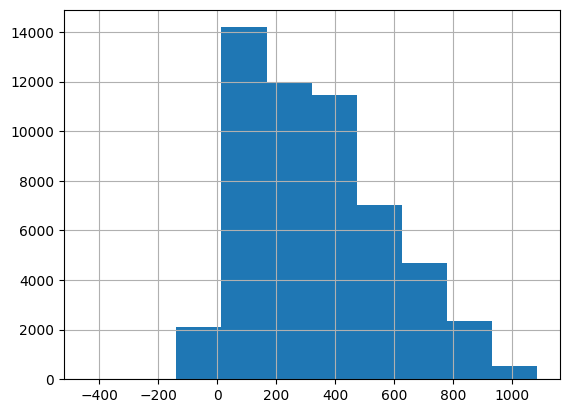

In [140]:
training_data['DAY_DIFF_TARGET'].hist()

<Axes: >

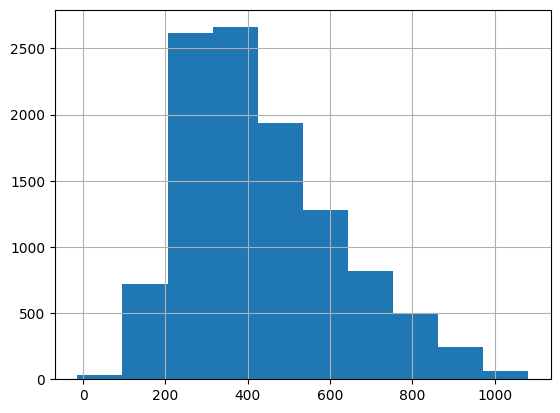

In [141]:
training_data[training_data['TARGET_EVENT'] == 'K']['DAY_DIFF_TARGET'].hist()

In [145]:
for cluster, group_data in training_data.groupby('CLUSTER'):
        # Filter data where 'DAY_DIFF_TARGET' is 1 (which I assume means defaulted in your case)
    defaulted_data = group_data[group_data['TARGET_EVENT'] == 'K']
    print(f'Cluster {cluster}:')    
    print(training_data['DAY_DIFF_TARGET'].value_counts(dropna=False))

Cluster 0:
DAY_DIFF_TARGET
NaN       1547322
1.0           356
28.0          207
7.0           206
29.0          178
           ...   
1050.0          1
975.0           1
1058.0          1
1000.0          1
1047.0          1
Name: count, Length: 1105, dtype: int64
Cluster 1:
DAY_DIFF_TARGET
NaN       1547322
1.0           356
28.0          207
7.0           206
29.0          178
           ...   
1050.0          1
975.0           1
1058.0          1
1000.0          1
1047.0          1
Name: count, Length: 1105, dtype: int64
Cluster 2:
DAY_DIFF_TARGET
NaN       1547322
1.0           356
28.0          207
7.0           206
29.0          178
           ...   
1050.0          1
975.0           1
1058.0          1
1000.0          1
1047.0          1
Name: count, Length: 1105, dtype: int64
Cluster 3:
DAY_DIFF_TARGET
NaN       1547322
1.0           356
28.0          207
7.0           206
29.0          178
           ...   
1050.0          1
975.0           1
1058.0          1
1000.0          

In [149]:
from scipy.optimize import minimize

def negative_log_likelihood(params, data):
    a, loc, scale = params
    return -np.sum(gamma.logpdf(data, a, loc, scale))

# Loop through each cluster as before
for cluster, group_data in training_data.groupby('CLUSTER'):
        # Filter data where 'DAY_DIFF_TARGET' is 1 (which I assume means defaulted in your case)
    defaulted_data = group_data[group_data['TARGET_EVENT'] == 'K'].dropna(subset=['DAY_DIFF_TARGET'])

    # Ensure all values in 'DAY_DIFF_TARGET' are non-negative
    defaulted_data['DAY_DIFF_TARGET_CLIPPED'] = defaulted_data['DAY_DIFF_TARGET'].clip(lower=0)

    if len(defaulted_data) == 0:
        continue
    
    data = defaulted_data['DAY_DIFF_TARGET_CLIPPED']
    print(data.std())
    if data.std() == 0:
        continue
    print('------------------')
    print(data.value_counts())  
    gamma_params = gamma.fit(data, )
    print(gamma_params)
    # Initial parameter guess
    cluster_gamma_params[cluster] = gamma_params    # init_params = [1, 0, 1]
    
    # # Boundaries for the parameters
    # param_bounds = [(1e-6, None)] * 3  # Change this based on what you think the parameters should be
    
    # # Minimize the negative log-likelihood
    # result = minimize(negative_log_likelihood, init_params, args=(data,), bounds=param_bounds)
    
    # if result.success:
    #     a, b, c = result.x
    #     cluster_gamma_params[cluster] = {'a': a, 'b': b, 'c': c}
    # else:
    #     print(f"Optimization failed for cluster {cluster}: {result.message}")

# Show the fitted parameters
print(cluster_gamma_params)


194.43085400534378
------------------
DAY_DIFF_TARGET_CLIPPED
375.0    2
90.0     2
93.0     2
176.0    2
115.0    2
245.0    2
106.0    2
345.0    2
99.0     2
104.0    2
180.0    1
583.0    1
134.0    1
489.0    1
305.0    1
402.0    1
354.0    1
837.0    1
715.0    1
366.0    1
382.0    1
Name: count, dtype: int64
(0.7214514081980099, 89.99999999999997, 139.30982161263393)
172.00868988136781
------------------
DAY_DIFF_TARGET_CLIPPED
630.0    4
295.0    4
660.0    4
693.0    4
559.0    3
        ..
546.0    1
392.0    1
488.0    1
498.0    1
199.0    1
Name: count, Length: 128, dtype: int64
(3.292562282334722, 137.53765895269862, 97.09092708404526)
230.80001555348122
------------------
DAY_DIFF_TARGET_CLIPPED
99.0     8
190.0    7
186.0    7
110.0    7
105.0    7
        ..
409.0    1
334.0    1
609.0    1
365.0    1
676.0    1
Name: count, Length: 284, dtype: int64
(3.3810886346692737, -27.814826710095595, 130.61794206501958)
182.11099607548624
------------------
DAY_DIFF_TARGET_CL

In [150]:
cluster_gamma_params

{0: (0.7214514081980099, 89.99999999999997, 139.30982161263393),
 1: (3.292562282334722, 137.53765895269862, 97.09092708404526),
 3: (3.3810886346692737, -27.814826710095595, 130.61794206501958),
 4: (5.74004790444844, 37.2743263225548, 75.70850035848434),
 6: (2.478649465070863, 188.75825951734043, 116.29685370409697),
 8: (4.801983186409137, -83.20393264165438, 104.6779147722512),
 9: (2.5916077701431908, 121.3316833479167, 112.43097525620493),
 5: (8.75711288806173, -144.56213756027466, 67.26580872420175),
 7: (0.8264807469318534, 260.99999999999994, 111.11489680088098)}

0 (0.7214514081980099, 89.99999999999997, 139.30982161263393)
1 (3.292562282334722, 137.53765895269862, 97.09092708404526)
3 (3.3810886346692737, -27.814826710095595, 130.61794206501958)
4 (5.74004790444844, 37.2743263225548, 75.70850035848434)
6 (2.478649465070863, 188.75825951734043, 116.29685370409697)
8 (4.801983186409137, -83.20393264165438, 104.6779147722512)
9 (2.5916077701431908, 121.3316833479167, 112.43097525620493)
5 (8.75711288806173, -144.56213756027466, 67.26580872420175)
7 (0.8264807469318534, 260.99999999999994, 111.11489680088098)


<Figure size 640x480 with 0 Axes>

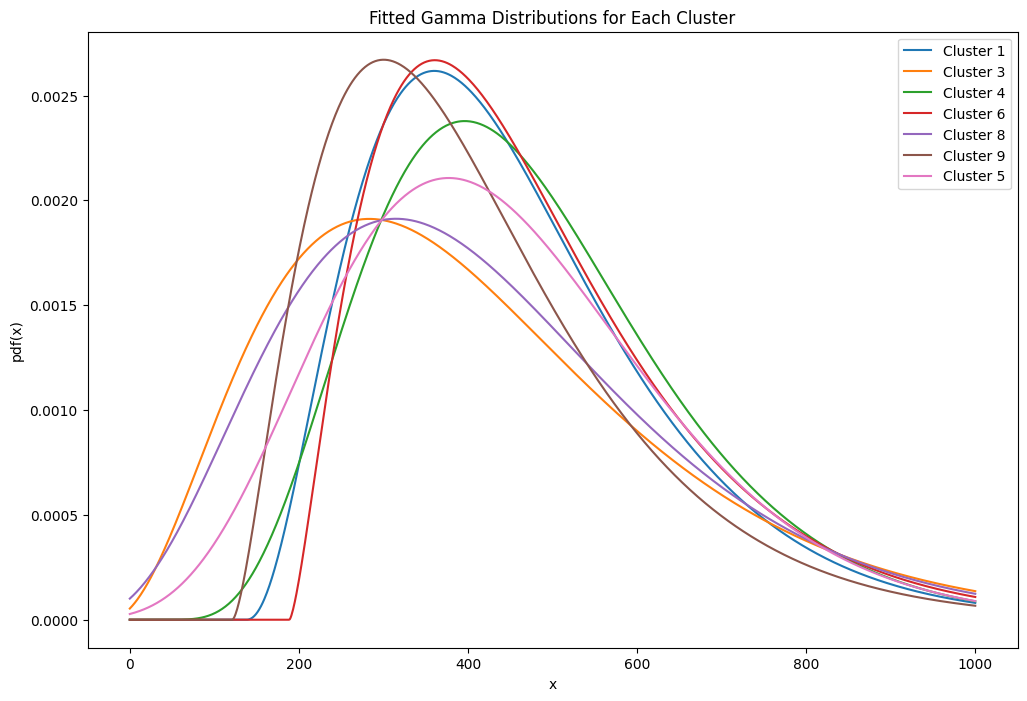

In [162]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma

# Setting the color map to 'viridis' as per your request
plt.set_cmap('viridis')

# Initialize a figure
plt.figure(figsize=(12, 8))

# Loop through each cluster and its parameters
for cluster, params in cluster_gamma_params.items():
    # if cluster == 0 or cluster == 7:
    #     continue
    print(cluster, params)
    a, b, c = params[0], params[1], params[2]
    # Consult Máté
    if a < 1:
        continue
    # Generate x values
    x = np.linspace(0, 1000, 1000)
    
    # Generate y values based on the gamma pdf
    y = gamma.pdf(x, a, b, c)
    
    # Plot the curve
    plt.plot(x, y, label=f'Cluster {cluster}')


# Add title and labels
plt.title('Fitted Gamma Distributions for Each Cluster')
plt.xlabel('x')
plt.ylabel('pdf(x)')

# Add legend
plt.legend()

# Show plot
plt.show()


In [ ]:
submission = create_submission_file(training_data, predicted_probs, data_submission_example, filename='./predictions/logistic-regression-one-model.csv')

In [ ]:
predicted_probs = 'RANDOM_FOREST'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    y_column, 
    model1=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42),
    model2=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42),
)
training_data[predicted_probs] = probs
submission = create_submission_file(training_data, predicted_probs,data_submission_example, filename='./predictions/random-forrest-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv')

In [ ]:
predicted_probs = 'GRADIENT_BOOSTING_CLASSIFIER'
probs = train_and_predict_two_halves(
    training_data, 
    X_columns, 
    y_column, 
    model1=GradientBoostingClassifier(random_state=42),
    model2=GradientBoostingClassifier(random_state=42),
)
training_data[predicted_probs] = probs
submission = create_submission_file(training_data, predicted_probs,data_submission_example, filename='./predictions/gbc-2y-exp-no-multicolinearity-lognormal-time-no-dates.csv')

In [22]:
predicted_probs = 'XGBOOST'
xgb_params = {
    'learning_rate': 0.05,  # Increased learning rate to capture more data complexity
    'max_depth': 4,         # Increased max depth to capture more data complexity
    'min_child_weight': 3,  # Reduced for less regularization
    'gamma': 0.04,          # Reduced for less conservatism
    'subsample': 0.9,       # Increased for less overfitting control
    'colsample_bytree': 0.9,# Increased to use more features
    'scale_pos_weight': 66.56, # 98.52/1.48
    'reg_alpha': 0.1,       # Reduced for less L1 regularization
    'reg_lambda': 0.1,      # Reduced for less L2 regularization
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42      # Seed fixed at 42 as per your request
}
probs = train_and_predict(
    training_data, 
    X_columns, 
    y_column, 
    model1= xgb.XGBClassifier(**xgb_params),
)
training_data[predicted_probs] = probs
submission = create_submission_file(training_data, predicted_probs, data_submission_example, filename='./predictions/xgboost-tuned-2y-1y.csv')

Centering probabilities...
0.7425435848849226 1.734723475976807e-18 0.014800000000000002
Saved file: ./predictions/xgboost-tuned-2y-1y.csv


c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


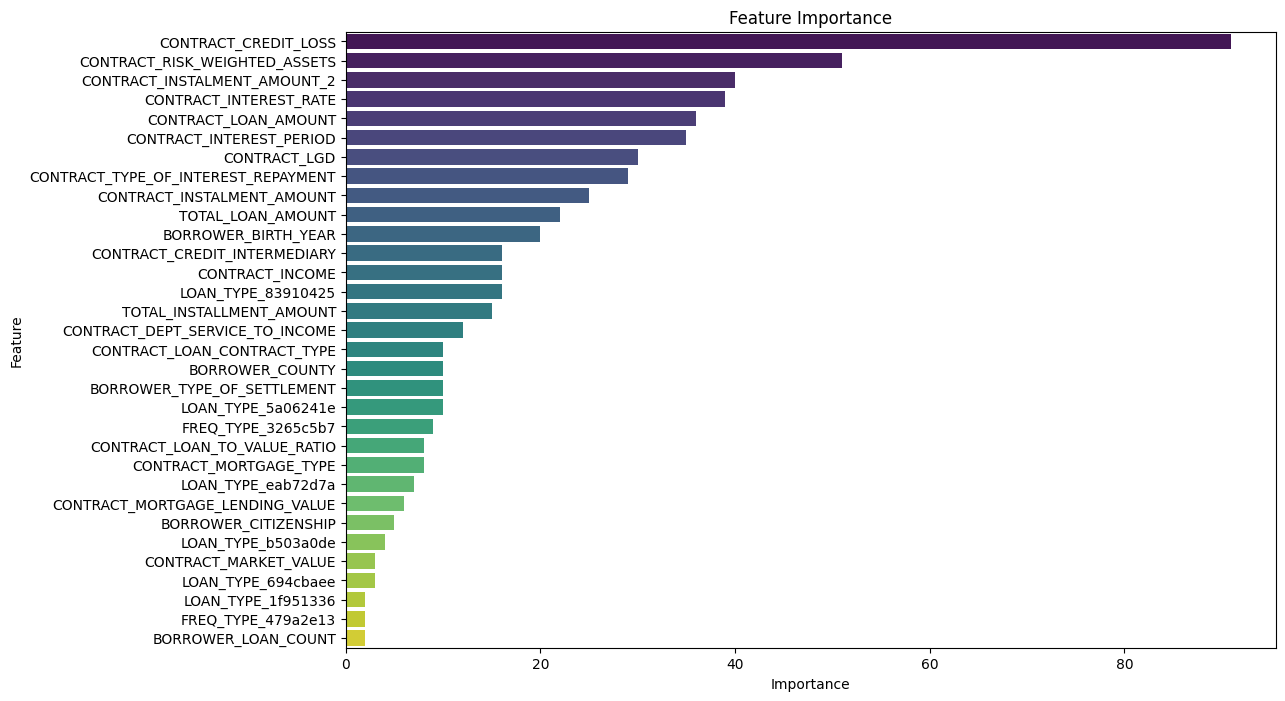

In [14]:
model, feature_importance = xgb_feature_importance(training_data, X_columns, y_column)


In [15]:
model, non_significant_vars = significant_features(training_data, X_columns, y_column)

         Current function value: 0.016244
         Iterations: 35


c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Logit Regression Results                             
Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
Model:                              Logit   Df Residuals:                  1601614
Method:                               MLE   Df Model:                           48
Date:                    Wed, 01 Nov 2023   Pseudo R-squ.:                  0.6004
Time:                            12:35:31   Log-Likelihood:                -26017.
converged:                          False   LL-Null:                       -65100.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -10.2494        nan        nan        nan         nan         nan
CONTRACT_CREDIT_INTERMED

In [23]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

xgb_params = {
    'learning_rate': 0.1,  # Increased learning rate to capture more data complexity
    'max_depth': 4,         # Increased max depth to capture more data complexity
    'min_child_weight': 2,  # Reduced for less regularization
    'gamma': 0.04,          # Reduced for less conservatism
    'subsample': 0.9,       # Increased for less overfitting control
    'colsample_bytree': 0.9,# Increased to use more features
    'scale_pos_weight': 66.56, # 98.52/1.48
    'reg_alpha': 0.05,       # Reduced for less L1 regularization
    'reg_lambda': 0.05,      # Reduced for less L2 regularization
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42      # Seed fixed at 42 as per your request
}

# xgb = xgb.XGBClassifier(**xgb_params)

models =  [
    # (LogisticRegression(max_iter=400, penalty=None, C=1.0, random_state=42),
    #  LogisticRegression(max_iter=400, penalty=None, C=1.0, random_state=42)),
    
   ( xgb.XGBClassifier(**xgb_params),
      xgb.XGBClassifier(**xgb_params)),
]

best_logloss = 100
best_models = None
for model in models:

    logloss = test_model_2y_1y(
        training_data, 
        X_columns, 
        'TARGET_EVENT_BINARY_1Y',
        model1=model[0],
        model2=model[1],
    )
    if logloss < best_logloss:
        best_logloss = logloss
        best_models = model
    print(model[0])
    print('Logloss is ', logloss)
    print('-----------------------------------------')

Evaluation of Model 1 on df2:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    509478
           1       0.35      0.98      0.52      5071

    accuracy                           0.98    514549
   macro avg       0.68      0.98      0.75    514549
weighted avg       0.99      0.98      0.99    514549

Log Loss:
0.04614388476331583
Confusion Matrix:
[[500293   9185]
 [    78   4993]]
Evaluation of Model 2 on df1:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    509480
           1       0.35      0.99      0.51      5069

    accuracy                           0.98    514549
   macro avg       0.67      0.98      0.75    514549
weighted avg       0.99      0.98      0.99    514549

Log Loss:
0.04712867027672399
Confusion Matrix:
[[500090   9390]
 [    64   5005]]
Centering probabilities...
0.5855057973099911 0.0 0.0148
Saved file: None


In [15]:
groups_by_size = {}

# Initialize a dictionary to hold covariance matrices by group size
cov_matrices_by_size = {}

# Group by 'BORROWER_ID' and iterate through the first 100 groups
for idx, (name, group) in enumerate(training_data.groupby('BORROWER_ID')):
    if idx % 100 == 0: 
        print('At index', idx)
        
    if idx == 50000:
        break
    
    # Sort the group by CONTRACT_DATE_OF_LOAN_AGREEMENT
    group = group.sort_values(by='CONTRACT_DATE_OF_LOAN_AGREEMENT')
    
    group_size = len(group)
    if group_size not in groups_by_size:
        groups_by_size[group_size] = []
        
    groups_by_size[group_size].append(group)

# Initialize a new dictionary to hold the merged DataFrames by size
merged_groups_by_size = {}

for size, dfs in groups_by_size.items():
    # Merge all DataFrames of the same size into a single DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)
    # Store the merged DataFrame in the new dictionary
    merged_groups_by_size[size] = merged_df

# Now, merged_groups_by_size contains the merged DataFrames categorized by group size


In [20]:
import json
import numpy as np
import pandas as pd

# Your code to generate groups_by_size and merged_groups_by_size

cov_matrices_by_size = {}

for size, merged_df in merged_groups_by_size.items():
    if size > 1:  # Covariance matrix for single-element arrays doesn't make sense
        try:
            cov_matrix = np.cov(merged_df['TARGET_EVENT_BINARY'].values.reshape(size,-1))
            if not np.isnan(cov_matrix).any():  # Check for NaN values
                cov_matrices_by_size[size] = cov_matrix.tolist()  # Convert numpy array to list for JSON serialization
        except Exception as e:
            print(f"An error occurred while calculating the covariance matrix for size {size}: {e}")

# Ensure that the dictionary contains only JSON-serializable items
serializable_cov_matrices_by_size = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in cov_matrices_by_size.items()}

# Save to JSON
with open('./data/cov_matrices_by_size.json', 'w') as f:
    json.dump(serializable_cov_matrices_by_size, f)


C:\Users\takat\AppData\Local\Temp\ipykernel_13332\2391036120.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov_matrix = np.cov(merged_df['TARGET_EVENT_BINARY'].values.reshape(size,-1))
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [21]:
cov_matrices_by_size

{2: [[0.005868589752778426, -3.2357827075016176e-05],
  [-3.2357827075016176e-05, 0.005451716043799604]],
 3: [[0.007337144521720125, -2.6009019928111114e-05, -2.6009019928111046e-05],
  [-2.6009019928111114e-05, 0.003507502116019551, -1.2385247584814735e-05],
  [-2.6009019928111046e-05, -1.2385247584814735e-05, 0.003507502116019557]],
 4: [[0.0023364421983921592,
   -1.3695440787761734e-05,
   -5.478176315104693e-06,
   -8.217264472657053e-06],
  [-1.3695440787761734e-05,
   0.005820562334798763,
   -1.3695440787761748e-05,
   -2.054316118164268e-05],
  [-5.478176315104693e-06,
   -1.3695440787761748e-05,
   0.0023364421983921558,
   -8.217264472657026e-06],
  [-8.217264472657053e-06,
   -2.054316118164268e-05,
   -8.217264472657026e-06,
   0.003500554665351909]],
 8: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 

In [34]:
# Save to JSON
import json

with open('cov_matrices_by_size.json', 'w') as f:
    json.dump(cov_matrices_by_size, f)